In [1]:
import scipy.io
import os
import numpy as np

In [2]:
# Define the main path and file paths
main_path = r'D:\Fateme A\23_Brain Electrophysiological Recording during Olfactory Stimulation in Mild Cognitive Impairment and Alzheimer Disease Patients An EEG Dataset'

In [3]:
import random

# Define file names
file_paths = {
    "AD": os.path.join(main_path, "AD.mat"),
    "normal": os.path.join(main_path, "normal.mat"),
    "MCI": os.path.join(main_path, "MCI.mat")
}

# Prepare storage per class
class_data = {
    "AD": [],
    "normal": [],
    "MCI": []
}

# Load and organize all trials by class
for label, file_path in file_paths.items():
    mat_data = scipy.io.loadmat(file_path)
    eeg_data = mat_data[label]  # Assuming variable name matches label

    for patient_id in range(eeg_data.shape[1]):  # shape: (1, N_patients)
        patient_data = eeg_data[0][patient_id]
        trials = patient_data[0]  # shape: channels x samples x trials

        # Split into individual trials and add to class list
        for i in range(trials.shape[2]):
            class_data[label].append(trials[:, :, i])  # One trial

# Calculate total trial counts per class
trial_counts = {label: len(trials) for label, trials in class_data.items()}
print("Trial counts per class:", trial_counts)

# Find the minimum number of trials across the 3 classes
min_trial_count = min(trial_counts.values())
print("trial number to balance classes:", min_trial_count)

# Randomly select min_trial_count trials from each class
balanced_data = []
balanced_labels = []

for label in class_data:
    selected_trials = random.sample(class_data[label], min_trial_count)
    balanced_data.extend(selected_trials)
    balanced_labels.extend([label] * min_trial_count)

# Convert to arrays
data_array = np.stack(balanced_data)  # shape: total_trials x channels x samples
labels_array = np.array(balanced_labels)

# Final output info
print("3 * 848 = ", data_array.shape[0])
print('we used random selection of trials to balance classes')

print("Final balanced dataset:")
print("Data shape:", data_array.shape)
print("Labels shape:", labels_array.shape)
print("Labels:", np.unique(labels_array, return_counts=True))


Trial counts per class: {'AD': 1352, 'normal': 1677, 'MCI': 848}
trial number to balance classes: 848
3 * 848 =  2544
we used random selection of trials to balance classes
Final balanced dataset:
Data shape: (2544, 4, 600)
Labels shape: (2544,)
Labels: (array(['AD', 'MCI', 'normal'], dtype='<U6'), array([848, 848, 848]))


## Transfer Entropy Function

In [4]:
from scipy.signal import hilbert
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy
from scipy.signal import butter, filtfilt
from collections import Counter

# Bandpass filter
def bandpass_filter(signal, lowcut=0.1, highcut=40.0, fs=200.0, order=3):
    """Apply a Butterworth bandpass filter to a signal."""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def compute_shannon_entropy(signal, bins=100):
    """Compute Shannon entropy of a signal (time domain) using histogram binning."""
    histogram, bin_edges = np.histogram(signal, bins=bins, density=True)
    probs = histogram / np.sum(histogram)  # Normalize to get probability distribution
    probs = probs[probs > 0]  # Remove zero entries to avoid log(0)
    return entropy(probs)

def extract_shannon_entropy_features(multichannel_signal):
    """
    Extract Shannon entropy features from all EEG channels in a trial.
    """
    features = []
    for channel_signal in multichannel_signal:
        filtered_signal = bandpass_filter(channel_signal, fs=200)
        entropy_val = compute_shannon_entropy(filtered_signal)
        features.append(entropy_val)
    return features  # List of 4 entropy values, one per channel

def transfer_entropy(source, target, delay=1, bins=10):
    """
    Calculate transfer entropy from source to target time series.
    
    Parameters:
    source: array-like, source time series
    target: array-like, target time series
    delay: int, time delay (default=1)
    bins: int, number of bins for discretization (default=10)
    
    Returns:
    float: transfer entropy value
    """
    # Ensure inputs are numpy arrays
    source = np.array(source)
    target = np.array(target)
    
    # Create discretized versions of the signals
    source_binned = np.digitize(source, np.linspace(min(source), max(source), bins))
    target_binned = np.digitize(target, np.linspace(min(target), max(target), bins))
    
    # Create time-shifted versions
    target_past = target_binned[:-delay]
    target_future = target_binned[delay:]
    source_past = source_binned[:-delay]
    
    # Calculate joint and marginal probabilities
    states = list(zip(target_future, target_past, source_past))
    p_joint = Counter(states)
    total_states = len(states)
    
    # Normalize to get probabilities
    for k in p_joint:
        p_joint[k] = p_joint[k] / total_states
    
    # Calculate conditional states
    states_condition = list(zip(target_past, source_past))
    p_condition = Counter(states_condition)
    for k in p_condition:
        p_condition[k] = p_condition[k] / total_states
    
    states_target = list(zip(target_future, target_past))
    p_target = Counter(states_target)
    for k in p_target:
        p_target[k] = p_target[k] / total_states
    
    # Calculate transfer entropy
    te = 0
    for state in p_joint:
        future, past, source_p = state
        if p_joint[state] > 0:
            dividend = p_joint[state] * p_condition[(past, source_p)]
            divisor = p_target[(future, past)] * p_condition[(past, source_p)]
            if divisor > 0:  # Add check to prevent division by zero
                te += p_joint[state] * np.log2(dividend / divisor)
    
    return te

import numpy as np
from scipy.signal import hilbert
from sklearn.preprocessing import KBinsDiscretizer

def compute_phase(signal):
    """Compute instantaneous phase via Hilbert transform."""
    analytic_signal = hilbert(signal)
    phase = np.angle(analytic_signal)
    return phase

def bin_phases(phases, n_bins):
    """Discretize continuous phases into n_bins states uniformly."""
    # phases in [-π, π]
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform', subsample=None)
    return est.fit_transform(phases.reshape(-1, 1)).astype(int).flatten()

def estimate_joint_probabilities(data, n_bins):
    """Estimate joint probability distribution from 2D array of binned variables."""
    # Each row = variable, columns = samples
    # data.shape = (variables, N)
    variables, N = data.shape
    joint_counts = np.zeros([n_bins]*variables, dtype=np.float64)
    for i in range(N):
        idx = tuple(data[:, i])
        joint_counts[idx] += 1
    joint_probs = joint_counts / joint_counts.sum()
    return joint_probs

def phase_transfer_entropy(signal_a, signal_b, delta=1, n_bins=8):
    """
    Computes Phase Transfer Entropy from signal_b (driver) to signal_a (target)
    using the formula from the image.
    """
    # Step 1: Compute instantaneous phases
    phase_a = compute_phase(signal_a)
    phase_b = compute_phase(signal_b)

    # Step 2: Embed
    # A_delta = future of A
    A_delta = phase_a[delta:]
    A_past = phase_a[:-delta]
    B_past = phase_b[:-delta]

    N_effective = len(A_delta)

    # Step 3: Bin phases
    A_delta_binned = bin_phases(A_delta, n_bins)
    A_past_binned = bin_phases(A_past, n_bins)
    B_past_binned = bin_phases(B_past, n_bins)

    # Step 4: Build joint data
    data_A_delta_A_B = np.vstack([A_delta_binned, A_past_binned, B_past_binned])
    data_A_delta_A = np.vstack([A_delta_binned, A_past_binned])

    # Step 5: Estimate probabilities
    p_A_delta_A_B = estimate_joint_probabilities(data_A_delta_A_B, n_bins)
    p_A_delta_A = estimate_joint_probabilities(data_A_delta_A, n_bins)

    # Step 6: Compute sum
    PTE = 0.0
    for i in range(n_bins):
        for j in range(n_bins):
            for k in range(n_bins):
                p_joint = p_A_delta_A_B[i, j, k]
                if p_joint == 0:
                    continue

                p_cond_AB = p_joint / (p_A_delta_A_B[:, j, k].sum() + 1e-12)
                p_cond_A = p_A_delta_A[i, j] / (p_A_delta_A[:, j].sum() + 1e-12)

                if p_cond_AB > 0 and p_cond_A > 0:
                    PTE += p_joint * np.log2(p_cond_AB / p_cond_A)

    return PTE


## Feature extraction 

In [5]:
from tqdm import tqdm

# Feature extraction
def process_data(data_array):
    """
    Process EEG data, computing transfer entropy between all unique channel pairs.
    
    Parameters:
    data_array: numpy array of shape (n_trials, n_channels, n_samples)
    
    Returns:
    X: numpy array of shape (n_trials, n_features)
    feature_names: list of feature names for channel pairs
    """
    n_trials, n_channels, n_samples = data_array.shape
    channel_pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3), (1,0),(2,0),(3,0),(2,1),(3,1),(3,2)]
    features = []
    
    # Generate feature names
    feature_names = []
    
    # Shannon entropy feature names (assuming one per channel)
    for ch in range(n_channels):
        feature_names.append(f'shannon_entropy_ch{ch}')
    
    # Phase transfer entropy feature names
    for src, tgt in channel_pairs:
        feature_names.append(f'phase_te_ch{src}_to_ch{tgt}')
    
    # Transfer entropy feature names
    for src, tgt in channel_pairs:
        feature_names.append(f'te_ch{src}_to_ch{tgt}')
    
    for trial in tqdm(range(n_trials), desc="Extracting features"):
        signal = np.array(data_array[trial, :, :], dtype=np.float64)
        filtered_signal = bandpass_filter(signal, fs=200)
        
        # Shannon entropy features
        shannon_entropy_features = extract_shannon_entropy_features(filtered_signal)  # Process all channels
        
        # Transfer entropy features (phase and simple)
        phase_te_features = []
        te_features = []
        for src, tgt in channel_pairs:
            phase_te_val = phase_transfer_entropy(filtered_signal[src], filtered_signal[tgt])
            phase_te_features.append(phase_te_val)
            te_val = transfer_entropy(filtered_signal[src], filtered_signal[tgt])
            te_features.append(te_val)

        # --- Concatenate all features
        all_features = shannon_entropy_features + phase_te_features + te_features
        features.append(all_features)
    
    X = np.array(features)
    return X, feature_names

## Comparing Classifiers

Extracting features: 100%|██████████| 2544/2544 [03:17<00:00, 12.87it/s]



=== Evaluating Features with 10-Fold Cross-Validation ===

=== Classifier Performance (10-fold Accuracy) ===

--- Running SVM ---


SVM Folds: 100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


SVM: 0.894 ± 0.018

--- Running Random Forest ---


Random Forest Folds: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Random Forest: 0.880 ± 0.020

--- Running Naive Bayes ---


Naive Bayes Folds: 100%|██████████| 10/10 [00:00<00:00, 216.59it/s]


Naive Bayes: 0.702 ± 0.024

--- Running Logistic Regression ---


Logistic Regression Folds: 100%|██████████| 10/10 [00:00<00:00, 11.53it/s]


Logistic Regression: 0.812 ± 0.025

--- Running Decision Tree ---


Decision Tree Folds: 100%|██████████| 10/10 [00:00<00:00, 12.15it/s]


Decision Tree: 0.807 ± 0.018


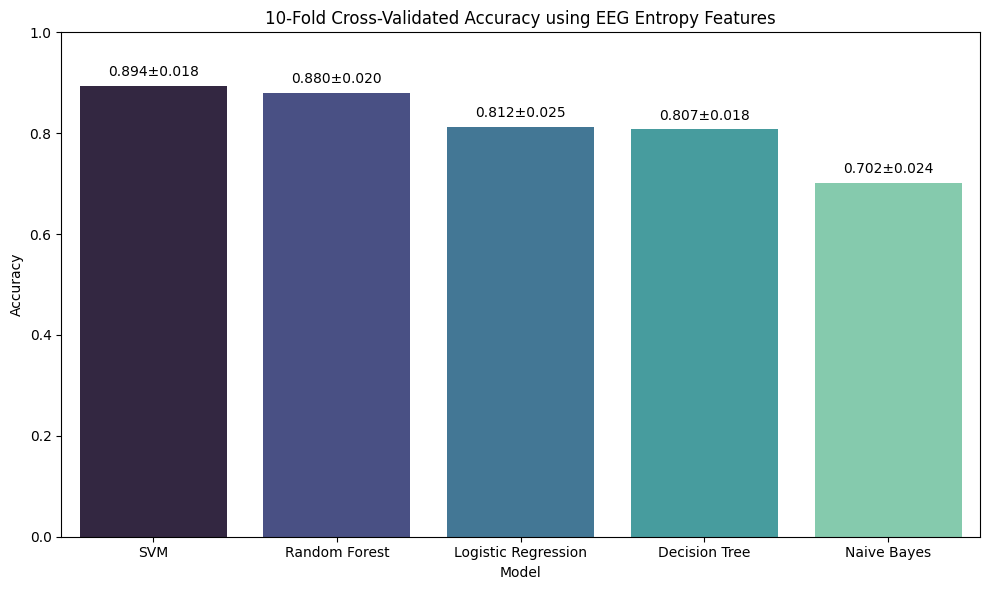

In [30]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from tqdm import tqdm

# Define classifiers
classifiers = {
    'SVM': SVC(kernel='rbf', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=1000,
        solver='lbfgs',
        tol=1e-4,
        C=1.0
    ),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Extract features
X = process_data(data_array)

# Encode labels (already balanced, one label per trial)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels_array)

# --- Main evaluation function ---
def evaluate_features(X, y_encoded):
    print("\n=== Evaluating Features with 10-Fold Cross-Validation ===")

    # Cross-validation setup
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    results = {}
    print("\n=== Classifier Performance (10-fold Accuracy) ===")

    for name, clf in classifiers.items():
        print(f"\n--- Running {name} ---")

        fold_scores = []

        for i, (train_idx, test_idx) in tqdm(enumerate(skf.split(X, y_encoded), 1), total=10, desc=f'{name} Folds'):
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', clf)
            ])
            pipeline.fit(X[train_idx], y_encoded[train_idx])
            score = pipeline.score(X[test_idx], y_encoded[test_idx])
            fold_scores.append(score)
        
        scores = np.array(fold_scores)

        # scores = cross_val_score(pipeline, X, y_encoded, cv=skf, scoring='accuracy')

        results[name] = {
            'Mean Accuracy': np.mean(scores),
            'Std Accuracy': np.std(scores),
            'All Scores': scores
        }

        print(f"{name}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

    # Plot mean accuracies
    accuracy_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Mean Accuracy': [results[m]['Mean Accuracy'] for m in results],
        'Std Accuracy': [results[m]['Std Accuracy'] for m in results]
    }).sort_values(by='Mean Accuracy', ascending=False)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        x='Model',
        y='Mean Accuracy',
        data=accuracy_df,
        hue='Model',
        palette='mako',
        legend=False
    )

    for p, (_, row) in zip(ax.patches, accuracy_df.iterrows()):
        ax.annotate(f'{row["Mean Accuracy"]:.3f}±{row["Std Accuracy"]:.3f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

    plt.title("10-Fold Cross-Validated Accuracy using EEG Entropy Features")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    return results

results = evaluate_features(X, y_encoded)


## Feature Importance

In [10]:
from sklearn.feature_selection import SelectFromModel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

def feature_importance_and_selection(X, y, feature_names=None, plot_top_n=28):
    """
    Evaluate and select important features using RandomForest.
    
    Parameters:
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Label vector.
        feature_names (list): Optional, names of features for plotting.
        plot_top_n (int): Number of top features to display.

    Returns:
        X_selected (np.ndarray): Subset of X with selected features.
        selected_indices (np.ndarray): Indices of selected features.
        selected_feature_names (list): Names of selected features.
    """
    print("\n=== Feature Importance & Selection using Random Forest ===")

    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)

    # Get importance scores
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Plot top N important features
    top_n = min(plot_top_n, len(importances))
    
    plt.figure(figsize=(12, 8))
    top_features = [feature_names[i] if feature_names else f'Feature_{i}' for i in indices[:top_n]]
    top_importances = importances[indices[:top_n]]
    
    sns.barplot(y=top_features, x=top_importances, palette='viridis')
    plt.title(f"Top {top_n} Feature Importances (Random Forest)")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    # Select important features (threshold = mean)
    selector = SelectFromModel(rf, threshold='mean', prefit=True)
    X_selected = selector.transform(X)
    selected_indices = selector.get_support(indices=True)
    
    selected_feature_names = [feature_names[i] for i in selected_indices] if feature_names else None
    
    print(f"Selected {X_selected.shape[1]} features out of {X.shape[1]}")
    
    if selected_feature_names:
        print("\nSelected features:")
        for i, name in enumerate(selected_feature_names):
            print(f"{i+1:2d}. {name}")

    return X_selected, selected_indices, selected_feature_names

def analyze_feature_types(feature_names, selected_indices, channel_names=None):
    """
    Analyze the types of selected features (Shannon, PhaseTE, TE) with focus on channels.
    
    Parameters:
    feature_names: List of all feature names
    selected_indices: Indices of selected features
    channel_names: List of channel names (e.g., ['Fp1', 'Fz', 'Cz', 'Pz'])
    """
    print("\n=== Feature Type Analysis (Channel-Based) ===")
    
    selected_features = [feature_names[i] for i in selected_indices]
    
    # Helper function to convert channel index to name
    def get_channel_name(ch_idx_str, channel_names):
        if channel_names is None:
            return ch_idx_str
        try:
            # Extract number from 'ch0', 'ch1', etc.
            idx = int(ch_idx_str.replace('ch', ''))
            return channel_names[idx] if idx < len(channel_names) else ch_idx_str
        except (ValueError, IndexError):
            return ch_idx_str
    
    # Count feature types
    feature_types = {'Shannon': 0, 'PhaseTE': 0, 'TE': 0}
    channel_counts = {}
    channel_pair_counts = {}
    
    for feature in selected_features:
        if 'shannon_entropy' in feature:
            feature_types['Shannon'] += 1
            # Extract channel from shannon_entropy_ch0, shannon_entropy_ch1, etc.
            parts = feature.split('_')
            if len(parts) >= 3 and parts[2].startswith('ch'):
                ch_idx_str = parts[2]  # e.g., 'ch0', 'ch1'
                channel_name = get_channel_name(ch_idx_str, channel_names)
                channel_counts[channel_name] = channel_counts.get(channel_name, 0) + 1
                
        elif 'phase_te' in feature:
            feature_types['PhaseTE'] += 1
            # Extract channel pair from phase_te_ch0_to_ch1
            if '_to_' in feature:
                parts = feature.split('_')
                if len(parts) >= 5:
                    src_ch_idx = parts[2]  # e.g., 'ch0'
                    tgt_ch_idx = parts[4]  # e.g., 'ch1'
                    src_name = get_channel_name(src_ch_idx, channel_names)
                    tgt_name = get_channel_name(tgt_ch_idx, channel_names)
                    pair = f"{src_name}→{tgt_name}"
                    channel_pair_counts[pair] = channel_pair_counts.get(pair, 0) + 1
                    # Also count individual channels
                    channel_counts[src_name] = channel_counts.get(src_name, 0) + 1
                    channel_counts[tgt_name] = channel_counts.get(tgt_name, 0) + 1
                    
        elif feature.startswith('te_ch') and '_to_' in feature:
            feature_types['TE'] += 1
            # Extract channel pair from te_ch0_to_ch1
            parts = feature.split('_')
            if len(parts) >= 4:
                src_ch_idx = parts[1]  # e.g., 'ch0'
                tgt_ch_idx = parts[3]  # e.g., 'ch1'
                src_name = get_channel_name(src_ch_idx, channel_names)
                tgt_name = get_channel_name(tgt_ch_idx, channel_names)
                pair = f"{src_name}→{tgt_name}"
                channel_pair_counts[pair] = channel_pair_counts.get(pair, 0) + 1
                # Also count individual channels
                channel_counts[src_name] = channel_counts.get(src_name, 0) + 1
                channel_counts[tgt_name] = channel_counts.get(tgt_name, 0) + 1
    
    # Create plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Feature types pie chart
    if any(feature_types.values()):
        non_zero_types = {k: v for k, v in feature_types.items() if v > 0}
        axes[0].pie(non_zero_types.values(), labels=non_zero_types.keys(), autopct='%1.1f%%')
        axes[0].set_title('Selected Feature Types')
    else:
        axes[0].text(0.5, 0.5, 'No features selected', ha='center', va='center')
        axes[0].set_title('Selected Feature Types')
    
    # 2. Individual channel involvement
    if channel_counts:
        # Sort channels by name if using actual channel names, otherwise by key
        if channel_names:
            # Sort by the original order in channel_names if possible
            available_channels = [ch for ch in channel_names if ch in channel_counts]
            other_channels = [ch for ch in channel_counts.keys() if ch not in channel_names]
            sorted_channels = available_channels + sorted(other_channels)
        else:
            sorted_channels = sorted(channel_counts.keys())
            
        channel_values = [channel_counts[ch] for ch in sorted_channels]
        bars = axes[1].bar(sorted_channels, channel_values, color='skyblue')
        axes[1].set_title('Channel Involvement in Selected Features')
        axes[1].set_ylabel('Number of Features')
        axes[1].set_xlabel('Channel')
        axes[1].tick_params(axis='x', rotation=45)  # Rotate labels for better readability
        
        # Add value labels on bars
        for bar, value in zip(bars, channel_values):
            axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                        str(value), ha='center', va='bottom')
    else:
        axes[1].text(0.5, 0.5, 'No channel data', ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Channel Involvement in Selected Features')
    
    # 3. Channel pair connections (for transfer entropy features)
    if channel_pair_counts:
        pairs = list(channel_pair_counts.keys())
        counts = list(channel_pair_counts.values())
        
        # Create horizontal bar plot for better readability
        y_pos = np.arange(len(pairs))
        bars = axes[2].barh(y_pos, counts, color='lightcoral')
        axes[2].set_yticks(y_pos)
        axes[2].set_yticklabels(pairs)
        axes[2].set_title('Channel Pair Connections\n(Transfer Entropy Features)')
        axes[2].set_xlabel('Number of Features')
        
        # Add value labels on bars
        for bar, value in zip(bars, counts):
            axes[2].text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                        str(value), ha='left', va='center')
    else:
        axes[2].text(0.5, 0.5, 'No transfer entropy\nfeatures selected', 
                    ha='center', va='center', transform=axes[2].transAxes)
        axes[2].set_title('Channel Pair Connections\n(Transfer Entropy Features)')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary:")
    print(f"Total selected features: {len(selected_features)}")
    for ftype, count in feature_types.items():
        if count > 0:
            print(f"  {ftype}: {count} features")
    
    if channel_counts:
        print(f"\nMost involved channels:")
        sorted_channels = sorted(channel_counts.items(), key=lambda x: x[1], reverse=True)
        for ch, count in sorted_channels[:4]:  # Show top 4
            print(f"  {ch}: {count} features")
    
    if channel_pair_counts:
        print(f"\nMost important channel connections:")
        sorted_pairs = sorted(channel_pair_counts.items(), key=lambda x: x[1], reverse=True)
        for pair, count in sorted_pairs[:5]:  # Show top 5
            print(f"  {pair}: {count} features")


Step 1: Feature Extraction


Extracting features: 100%|██████████| 2544/2544 [03:18<00:00, 12.84it/s]



Step 2: Label Encoding

Step 4: Feature Importance Analysis

=== Feature Importance & Selection using Random Forest ===


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13376\155768148.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_features, x=top_importances, palette='viridis')


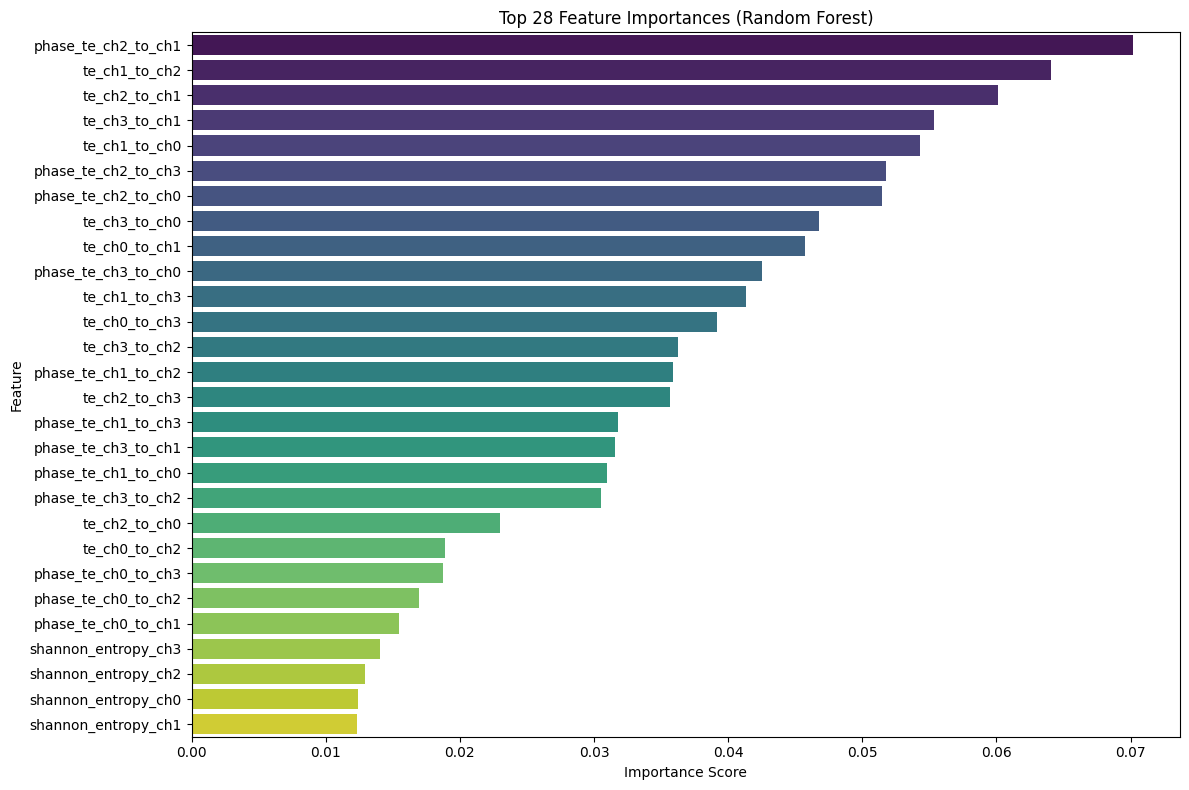

Selected 14 features out of 28

Selected features:
 1. phase_te_ch1_to_ch2
 2. phase_te_ch2_to_ch3
 3. phase_te_ch2_to_ch0
 4. phase_te_ch3_to_ch0
 5. phase_te_ch2_to_ch1
 6. te_ch0_to_ch1
 7. te_ch0_to_ch3
 8. te_ch1_to_ch2
 9. te_ch1_to_ch3
10. te_ch1_to_ch0
11. te_ch3_to_ch0
12. te_ch2_to_ch1
13. te_ch3_to_ch1
14. te_ch3_to_ch2


In [11]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Step 1: Extract features
print("\nStep 1: Feature Extraction")
X, feature_names = process_data(data_array)

# Step 2: Encode labels
print("\nStep 2: Label Encoding")
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels_array)

# Step 4: Feature importance and selection
print("\nStep 4: Feature Importance Analysis")
X_selected, selected_indices, selected_feature_names = feature_importance_and_selection(
    X, y_encoded, feature_names, plot_top_n=len(feature_names))




=== Feature Type Analysis (Channel-Based) ===


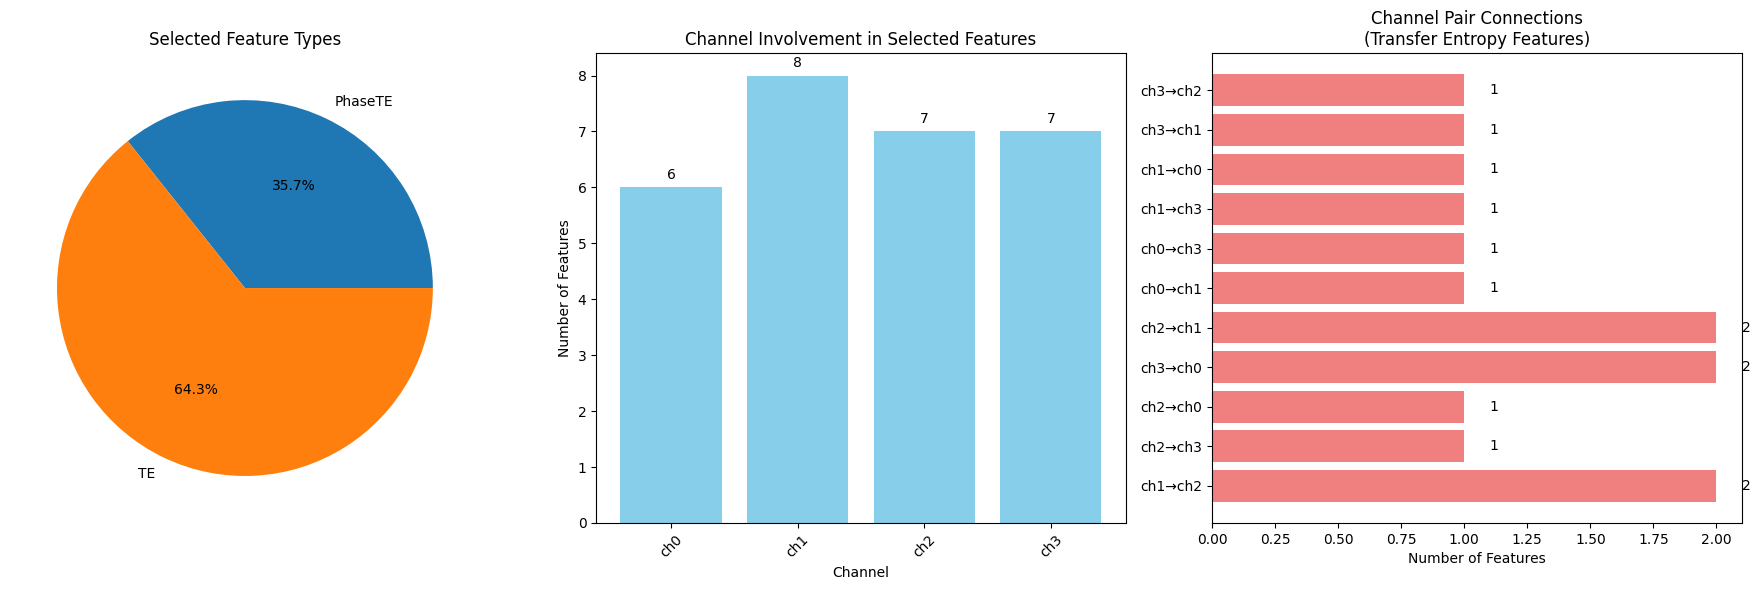


Summary:
Total selected features: 14
  PhaseTE: 5 features
  TE: 9 features

Most involved channels:
  ch1: 8 features
  ch2: 7 features
  ch3: 7 features
  ch0: 6 features

Most important channel connections:
  ch1→ch2: 2 features
  ch3→ch0: 2 features
  ch2→ch1: 2 features
  ch2→ch3: 1 features
  ch2→ch0: 1 features


In [12]:
analyze_feature_types(feature_names, selected_indices)

In [ ]:
# from sklearn.feature_selection import SelectFromModel

# def feature_importance_and_selection(X, y, feature_names=None, plot_top_n=28):
#     """
#     Evaluate and select important features using RandomForest.
    
#     Parameters:
#         X (np.ndarray): Feature matrix.
#         y (np.ndarray): Label vector.
#         feature_names (list): Optional, names of features for plotting.
#         plot_top_n (int): Number of top features to display.

#     Returns:
#         selected_features (np.ndarray): Subset of X with selected features.
#         selected_indices (np.ndarray): Indices of selected features.
#     """
#     print("\n=== Feature Importance & Selection using Random Forest ===")

#     # Train Random Forest
#     rf = RandomForestClassifier(n_estimators=100, random_state=42)
#     rf.fit(X, y)

#     # Get importance
#     importances = rf.feature_importances_
#     indices = np.argsort(importances)[::-1]

#     # Plot top N important features
#     top_n = min(plot_top_n, len(importances))
#     plt.figure(figsize=(10, 6))
#     sns.barplot(x=importances[indices[:top_n]], y=[feature_names[i] if feature_names else f'F{i}' for i in indices[:top_n]], palette='viridis')
#     plt.title("Top Feature Importances (Random Forest)")
#     plt.xlabel("Importance Score")
#     plt.ylabel("Feature")
#     plt.tight_layout()
#     plt.show()

#     # Select important features (threshold = mean)
#     selector = SelectFromModel(rf, threshold='mean', prefit=True)
#     X_selected = selector.transform(X)
#     selected_indices = selector.get_support(indices=True)
    
#     print(f"Selected {X_selected.shape[1]} features out of {X.shape[1]}")

#     return X_selected, selected_indices



=== Feature Importance & Selection using Random Forest ===


C:\Users\iliya\AppData\Local\Temp\ipykernel_6832\2900815168.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices[:top_n]], y=[feature_names[i] if feature_names else f'F{i}' for i in indices[:top_n]], palette='viridis')


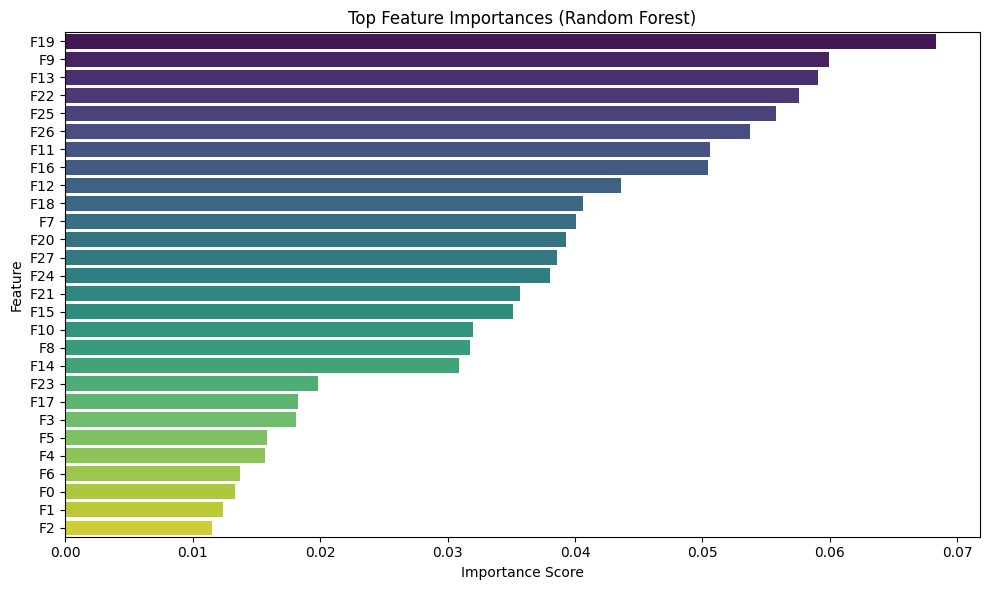

Selected 14 features out of 28


In [29]:
from sklearn.model_selection import train_test_split

# 80-20 split (20% test, 80% train)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
X_selected, selected_indices = feature_importance_and_selection(X_train, y_train, feature_names=None, plot_top_n=28)

# Test with selected features


=== Random Forest Accuracy on Test Set with Selected Features: 0.866 ===

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       169
           1       0.97      0.98      0.98       170
           2       0.83      0.79      0.81       170

    accuracy                           0.87       509
   macro avg       0.87      0.87      0.87       509
weighted avg       0.87      0.87      0.87       509



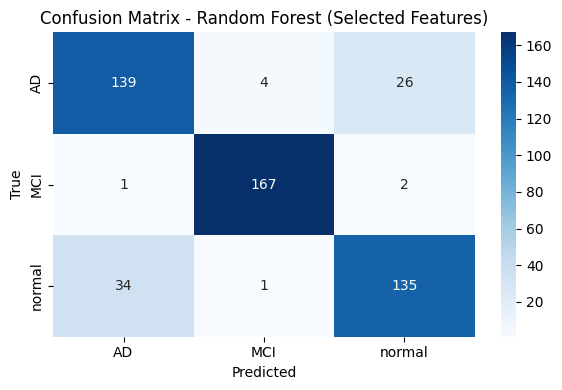

In [9]:
# Optional: Apply the same feature selection to test set
X_test_selected = X_test[:, selected_indices]
X_train_selected = X_train[:, selected_indices]

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Train Random Forest on selected features
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_train_selected, y_train)

# Predict on test set
y_pred = rf_selected.predict(X_test_selected)

# Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"\n=== Random Forest Accuracy on Test Set with Selected Features: {acc:.3f} ===")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Optional: Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest (Selected Features)')
plt.tight_layout()
plt.show()


# Test SVM with selected features


=== SVM Accuracy on Test Set with Selected Features: 0.829 ===

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.88      0.79       169
           1       0.92      0.97      0.95       170
           2       0.89      0.64      0.75       170

    accuracy                           0.83       509
   macro avg       0.84      0.83      0.83       509
weighted avg       0.84      0.83      0.83       509



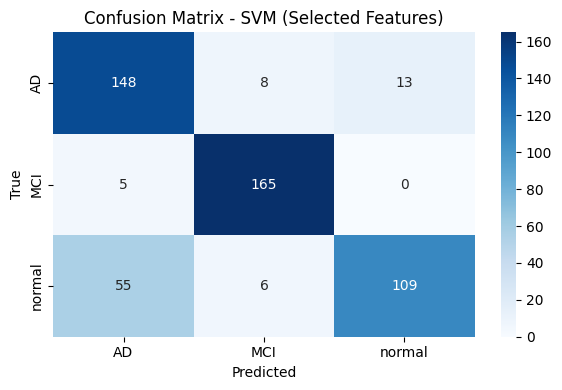

In [10]:
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Apply the same feature selection to test set
X_test_selected = X_test[:, selected_indices]
X_train_selected = X_train[:, selected_indices]

# Train SVM on selected features
svm_selected = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)  # RBF kernel is default
svm_selected.fit(X_train_selected, y_train)

# Predict on test set
y_pred = svm_selected.predict(X_test_selected)

# Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"\n=== SVM Accuracy on Test Set with Selected Features: {acc:.3f} ===")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SVM (Selected Features)')
plt.tight_layout()
plt.show()


# Sequential Feature Selection (Forward)


=== Sequential Feature Selection (Random Forest, Single Train/Test Split) ===
Selected 8 features: [2, 4, 8, 10, 12, 13, 14, 15]

=== Random Forest Accuracy on Test Set with Selected Features: 0.886 ===

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       169
           1       0.97      0.98      0.97       170
           2       0.86      0.83      0.84       170

    accuracy                           0.89       509
   macro avg       0.89      0.89      0.89       509
weighted avg       0.89      0.89      0.89       509



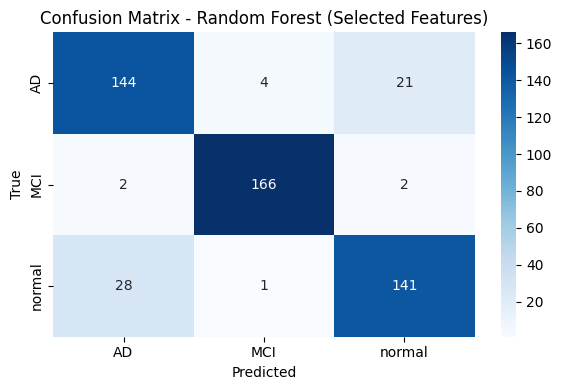

In [11]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np

# --- Sequential Feature Selection (Random Forest, single split) ---
def sequential_feature_selection_rf(X_train, y_train, X_test, y_test):
    print("\n=== Sequential Feature Selection (Random Forest, Single Train/Test Split) ===")

    # # Single random split
    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
    # )

    rf = RandomForestClassifier(n_estimators=100, random_state=42)

    # Scale + SFS in a pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('sfs', SequentialFeatureSelector(
            rf,
            n_features_to_select="auto",  # Let it decide automatically
            direction='forward',
            scoring='accuracy',
            cv=None,   # No cross-validation
            n_jobs=-1
        ))
    ])

    # Fit SFS
    pipeline.fit(X_train, y_train)
    selected_mask = pipeline.named_steps['sfs'].get_support()
    selected_indices = np.where(selected_mask)[0]

    print(f"Selected {len(selected_indices)} features: {selected_indices.tolist()}")

    # Apply selection to train & test sets
    X_train_selected = X_train[:, selected_indices]
    X_test_selected = X_test[:, selected_indices]

    # Train final RF on selected features
    rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_selected.fit(X_train_selected, y_train)

    # Predict on test set
    y_pred = rf_selected.predict(X_test_selected)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== Random Forest Accuracy on Test Set with Selected Features: {acc:.3f} ===")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Random Forest (Selected Features)')
    plt.tight_layout()
    plt.show()

    return rf_selected, selected_indices

# Run RF SFS and get trained model + selected features
rf_model_sequential, sequential_selected_features = sequential_feature_selection_rf(X_train, y_train, X_test, y_test)


# SVM (sequential feature selection)


=== Sequential Feature Selection (SVM, Single Train/Test Split) ===
Selected 8 features: [2, 4, 7, 9, 10, 12, 13, 14]

=== SVM Accuracy on Test Set with Selected Features: 0.780 ===

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.83      0.74       169
           1       0.85      0.97      0.91       170
           2       0.88      0.54      0.67       170

    accuracy                           0.78       509
   macro avg       0.80      0.78      0.77       509
weighted avg       0.80      0.78      0.77       509



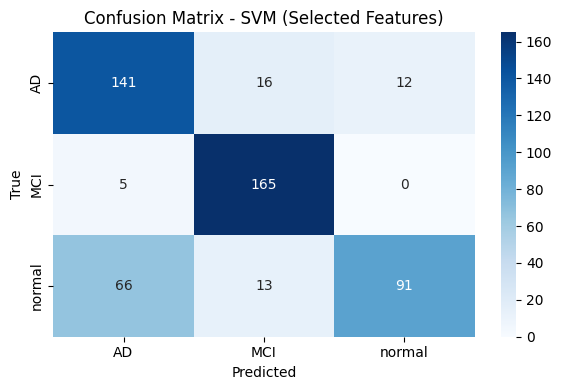

In [12]:
import warnings
warnings.filterwarnings("ignore")  # Suppress all warnings (optional, be careful in production)

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Sequential Feature Selection (SVM, single split) ---
def sequential_feature_selection_svm(X_train, y_train, X_test, y_test):
    print("\n=== Sequential Feature Selection (SVM, Single Train/Test Split) ===")

    # Base SVM model (linear kernel for interpretability, RBF if you prefer non-linear)
    svm_model = SVC(kernel='rbf', probability=False, random_state=42)

    # Scale + SFS in a pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('sfs', SequentialFeatureSelector(
            svm_model,
            n_features_to_select="auto",  # Let it decide automatically
            direction='forward',
            scoring='accuracy',
            cv=None,  # No cross-validation
            n_jobs=-1
        ))
    ])

    # Fit SFS
    pipeline.fit(X_train, y_train)
    selected_mask = pipeline.named_steps['sfs'].get_support()
    selected_indices = np.where(selected_mask)[0]

    print(f"Selected {len(selected_indices)} features: {selected_indices.tolist()}")

    # Apply selection to train & test sets
    X_train_selected = X_train[:, selected_indices]
    X_test_selected = X_test[:, selected_indices]

    # Train final SVM on selected features
    svm_selected = SVC(kernel='rbf', probability=False, random_state=42)
    svm_selected.fit(X_train_selected, y_train)

    # Predict on test set
    y_pred = svm_selected.predict(X_test_selected)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== SVM Accuracy on Test Set with Selected Features: {acc:.3f} ===")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - SVM (Selected Features)')
    plt.tight_layout()
    plt.show()

    return svm_selected, selected_indices

# Example run:
svm_model_sequential, sequential_selected_features = sequential_feature_selection_svm(
    X_train, y_train, X_test, y_test
)
